In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

ss = pd.read_csv('Street Sweeping Schedules.csv', low_memory=False)
print(f'Shape: {ss.shape}')
print(f'Columns: {list(ss.columns)}')

print(f'\n District Distribution')
print(ss['dist_name'].value_counts())

print(f'\nMissing Values')
for col in ss.columns:
    pct = ss[col].isnull().sum() / len(ss) * 100
    if pct > 0:
        print(f'  {col}: {pct:.1f}%')

Shape: (3757, 32)
Columns: ['main_id', 'st_name', 'dist', 'dist_name', 'start_time', 'end_time', 'side', 'from', 'to', 'miles', 'section', 'one_way', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'every_day', 'year_round', 'north_end_pilot', 'timestamp', 'parent', 'losta', 'hista', '_ingest_datetime']

 District Distribution
dist_name
North Dorchester    727
South Dorchester    521
Roxbury             382
Allston/Brighton    300
Jamaica Plain       284
South Boston        275
Charlestown         235
South End           192
East Boston         185
Mission Hill         95
Back Bay             95
North End            69
Downtown             64
Fenway/Kenmore       64
Beacon Hill          62
Multiple             55
Chinatown            50
DCR                  43
West End             28
Hyde Park            10
West Roxbury          8
Name: count, dtype: int64

Missing Values
  dist: 0.1%
  dist_name: 0.3%
  si

In [16]:
#  Convert boolean columns 
bool_cols = ['one_way', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5',
             'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
             'every_day', 'year_round', 'north_end_pilot']
for col in bool_cols:
    if col in ss.columns:
        ss[col] = ss[col].map({'t': True, 'f': False, True: True, False: False})

#  Fill missing 
ss['side'] = ss['side'].fillna('Unknown')
ss['dist_name'] = ss['dist_name'].fillna('Unknown')
ss['miles'] = pd.to_numeric(ss['miles'], errors='coerce').fillna(0)

#  Feature: sweep days per week 
day_cols = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
ss['sweep_days_per_week'] = ss[day_cols].sum(axis=1)

#  Feature: active weeks per month 
week_cols = ['week_1', 'week_2', 'week_3', 'week_4', 'week_5']
ss['active_weeks'] = ss[week_cols].sum(axis=1)

#  Feature: time slot 
def classify_time(start):
    try:
        h = int(str(start).split(':')[0])
        return 'Overnight' if h < 6 else ('Morning' if h < 12 else 'Afternoon')
    except:
        return 'Unknown'

ss['time_slot'] = ss['start_time'].apply(classify_time)

print(' New Features')
print(f'Sweep days/week distribution:\n{ss["sweep_days_per_week"].value_counts().sort_index()}')
print(f'\nTime slot distribution:\n{ss["time_slot"].value_counts()}')
print(f'\nActive weeks distribution:\n{ss["active_weeks"].value_counts().sort_index()}')

 New Features
Sweep days/week distribution:
sweep_days_per_week
0       6
1    3521
2       4
7     226
Name: count, dtype: int64

Time slot distribution:
time_slot
Morning      1881
Afternoon    1493
Overnight     383
Name: count, dtype: int64

Active weeks distribution:
active_weeks
0       6
1      41
2    3130
3     115
5     465
Name: count, dtype: int64


SLICE 1: District Representation
  North Dorchester: 19.4%
  South Dorchester: 13.9%
  Roxbury: 10.2%
  Allston/Brighton: 8.0%
  Jamaica Plain: 7.6%
  South Boston: 7.3%
  Charlestown: 6.3%
  South End: 5.1%
  East Boston: 4.9%
  Back Bay: 2.5%
  Mission Hill: 2.5%
  North End: 1.8% ⚠️ UNDERREPRESENTED
  Fenway/Kenmore: 1.7% ⚠️ UNDERREPRESENTED
  Downtown: 1.7% ⚠️ UNDERREPRESENTED
  Beacon Hill: 1.7% ⚠️ UNDERREPRESENTED
  Multiple: 1.5% ⚠️ UNDERREPRESENTED
  Chinatown: 1.3% ⚠️ UNDERREPRESENTED
  DCR: 1.1% ⚠️ UNDERREPRESENTED
  West End: 0.7% ⚠️ UNDERREPRESENTED
  Unknown: 0.3% ⚠️ UNDERREPRESENTED
  Hyde Park: 0.3% ⚠️ UNDERREPRESENTED
  West Roxbury: 0.2% ⚠️ UNDERREPRESENTED


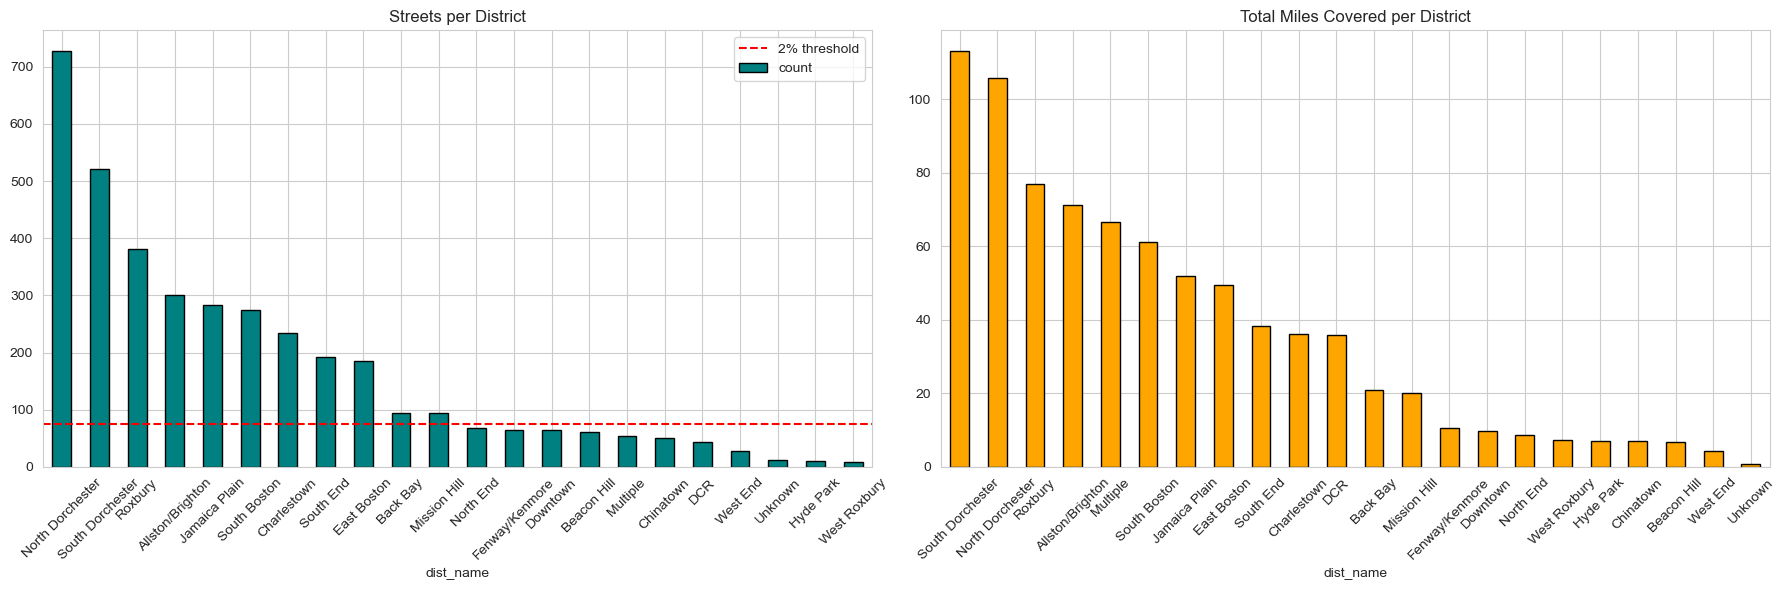


 Kruskal-Wallis: Sweep Days/Week by District 
H-statistic: 2068.3596
p-value:     0.000000
Significant: True

Mean sweep days/week by district:
dist_name
West End            7.000
Downtown            7.000
Chinatown           5.440
Back Bay            2.895
Multiple            2.309
Fenway/Kenmore      1.750
Beacon Hill         1.677
South End           1.406
South Boston        1.175
Charlestown         1.153
Roxbury             1.079
Mission Hill        1.063
North Dorchester    1.054
South Dorchester    1.012
Jamaica Plain       1.004
Unknown             1.000
Allston/Brighton    1.000
North End           1.000
East Boston         1.000
West Roxbury        1.000
Hyde Park           0.900
DCR                 0.884
Name: sweep_days_per_week, dtype: float64

CV: 0.9599

Chi-Square: Time Slot by District
Chi-square: 2094.5438, p-value: 0.000000
Significant: True
→ Time slot assignment DIFFERS across districts

 Districts with No Overnight Sweeping
2 districts: ['DCR', 'North End']


In [18]:
#  SLICE 1: District representation 
print('SLICE 1: District Representation')
dist_pct = ss['dist_name'].value_counts(normalize=True) * 100
for d, p in dist_pct.items():
    flag = ' ⚠️ UNDERREPRESENTED' if p < 2 else ''
    print(f'  {d}: {p:.1f}%{flag}')

#  Visualization 
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

ss['dist_name'].value_counts().plot(kind='bar', ax=axes[0], color='teal', edgecolor='black')
axes[0].axhline(y=len(ss)*0.02, color='red', linestyle='--', label='2% threshold')
axes[0].set_title('Streets per District')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

ss.groupby('dist_name')['miles'].sum().sort_values(ascending=False).plot(
    kind='bar', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('Total Miles Covered per District')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#  SLICE 2: Kruskal-Wallis — sweep frequency by district 
print('\n Kruskal-Wallis: Sweep Days/Week by District ')
groups = [g['sweep_days_per_week'].values for _, g in ss.groupby('dist_name') if len(g) >= 5]
stat, p = stats.kruskal(*groups)
print(f'H-statistic: {stat:.4f}')
print(f'p-value:     {p:.6f}')
print(f'Significant: {p < 0.05}')

freq_by_dist = ss.groupby('dist_name')['sweep_days_per_week'].mean().sort_values(ascending=False)
cv = freq_by_dist.std() / freq_by_dist.mean()
print(f'\nMean sweep days/week by district:')
print(freq_by_dist.round(3))
print(f'\nCV: {cv:.4f}')

#  Chi-Square: Time slot distribution across districts 
print('\nChi-Square: Time Slot by District')
contingency = pd.crosstab(ss['dist_name'], ss['time_slot'])
chi2, p_chi, dof, _ = stats.chi2_contingency(contingency)
print(f'Chi-square: {chi2:.4f}, p-value: {p_chi:.6f}')
print(f'Significant: {p_chi < 0.05}')
print(f'→ Time slot assignment {"DIFFERS" if p_chi < 0.05 else "is similar"} across districts')

#  Cross-slice: Districts with NO overnight sweeping 
print('\n Districts with No Overnight Sweeping')
cross = pd.crosstab(ss['dist_name'], ss['time_slot'])
if 'Overnight' in cross.columns:
    no_overnight = cross[cross['Overnight'] == 0].index.tolist()
    print(f'{len(no_overnight)} districts: {no_overnight}')
else:
    print('No overnight column found')

In [20]:
# MITIGATION 1: Oversample underrepresented districts
print('=== Mitigation 1: Oversampling ===')
target = int(len(ss) * 0.02)  # 2% threshold
ss_mit = ss.copy()
for dist, grp in ss.groupby('dist_name'):
    if len(grp) < target and len(grp) > 0:
        needed = target - len(grp)
        ss_mit = pd.concat([ss_mit, grp.sample(n=needed, replace=True, random_state=42)])
        print(f'  {dist}: {len(grp)} → {len(grp)+needed}')

print(f'\nOriginal: {len(ss)} → Mitigated: {len(ss_mit)}')

# MITIGATION 2: Normalize by district size (miles per street)
print('\n Mitigation 2: Per-Street Mile Normalization')
dist_stats = ss.groupby('dist_name').agg(
    total_streets=('main_id', 'count'),
    total_miles=('miles', 'sum'),
    avg_sweep_days=('sweep_days_per_week', 'mean')
).round(3)
dist_stats['miles_per_street'] = (dist_stats['total_miles'] / dist_stats['total_streets']).round(4)
print(dist_stats.sort_values('miles_per_street', ascending=False))
print('→ Normalizing by miles/street reveals TRUE service intensity vs just street count')

# MITIGATION 3: Stratified split by district
print('\n Mitigation 3: Stratified Split')
from sklearn.model_selection import train_test_split

# Group tiny districts together for stratification
ss['strat_district'] = ss['dist_name'].where(
    ss['dist_name'].isin(ss['dist_name'].value_counts().head(15).index), 'Other_Small'
)

train, temp = train_test_split(ss, test_size=0.30, random_state=42, stratify=ss['strat_district'])
val, test = train_test_split(temp, test_size=0.50, random_state=42, stratify=temp['strat_district'])

print(f'Train: {len(train)} | Val: {len(val)} | Test: {len(test)}')
print(f'\nNorth Dorchester % preserved:')
for name, split in [('Full', ss), ('Train', train), ('Val', val), ('Test', test)]:
    pct = (split['dist_name'] == 'North Dorchester').mean() * 100
    print(f'  {name}: {pct:.1f}%')
print('✓ District proportions preserved')

=== Mitigation 1: Oversampling ===
  Beacon Hill: 62 → 75
  Chinatown: 50 → 75
  DCR: 43 → 75
  Downtown: 64 → 75
  Fenway/Kenmore: 64 → 75
  Hyde Park: 10 → 75
  Multiple: 55 → 75
  North End: 69 → 75
  Unknown: 13 → 75
  West End: 28 → 75
  West Roxbury: 8 → 75

Original: 3757 → Mitigated: 4116

 Mitigation 2: Per-Street Mile Normalization
                  total_streets  total_miles  avg_sweep_days  miles_per_street
dist_name                                                                     
Multiple                     55       66.694           2.309            1.2126
West Roxbury                  8        7.299           1.000            0.9124
DCR                          43       35.981           0.884            0.8368
Hyde Park                    10        7.100           0.900            0.7100
East Boston                 185       49.465           1.000            0.2674
Allston/Brighton            300       71.259           1.000            0.2375
South Boston            